In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import numpy as np
import pandas as pd
import anndata as ad 
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sb
import scvi 
import torch #pytorch
import runpy
import pickle
from datetime import datetime
import celltypist
from celltypist import models

from os import sys
sys.path.append('/tmp/work/Visium/BRCA_2024/brca_scripts')
from visiumPipeline import processVisium
from applyCosineScores import cosineScores
from tumorSegmentation import retrieveTumorMask
from getRSigs import getRSigs
from py_AUCell import AUCell

sc.set_figure_params(figsize=(4,4))
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

#gettting model for celltypist
models.download_models(force_update = True)
model = models.Model.load(model = 'Immune_All_High.pkl')

#define sample poths, sample names and emptry dictionary

samples = ['2018838/PRE-01','2018838/PRE-02','2018838/POST-03','2018838/POST-05',
           '2018839/PRE-04','2018839/PRE-05','2018839/POST-06','2018839/POST-11']

# create pseudobulk profile
result = runpy.run_path('/tmp/work/Visium/BRCA_2024/brca_scripts/acquirePseudoBulkRef.py')
# read pseudobulk to variable
pb_df = pd.read_pickle('wu_2021_pseudobulk.pkl')

#grab the gene signatures
signatures_dict, signature_groups_list = getRSigs()

#prepare a list of paths for hires images required for tumor segmentation
image_paths = []
for sample in samples:
    image_path = '/tmp/work/Visium/' + sample + '/spatial/tissue_hires_image.png'
    image_paths.append(image_path)
    
sample_names = [os.path.basename(sample) for sample in samples]
visium_samples = variables = {name: None for name in sample_names} #variable names associated with emptry values in dictionary for storing data later

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
cffi mode is CFFI_MODE.ANY
R home found: /opt/conda/lib/R
R library path: 
LD_LIBRARY_PATH: 
Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.
/opt/conda/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


normalizing counts per cell
    finished (0:00:01)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50


2024-08-28 08:52:52.324224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:03)
normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/opt/conda/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
querying 1-11...
done.
Finished.
querying 1-7...
done.
Finished.
querying 1-4...
done.
Finished.
querying 1-3...
done.
Finished.
querying 1-12...
done.
Finished.
1 input query terms found dup hits:	[('ENSG00000072694', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-3...
done.
Finished.
querying 1-4...
done.
Finished.
1 input query terms found dup hits:	[('ENSG00000

In [2]:
import importlib
import sys

# Add the path where your custom module is located
sys.path.append('/tmp/work/Visium/BRCA_2024/brca_scripts')

# Import the module
import py_AUCell

# Now reload the module
importlib.reload(py_AUCell)
#process each of the samples

start_time = datetime.now()

for i in range(len(samples)):
    print('\n')
    print('Initial Processing of:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = processVisium(samples[i],model)
    print('\n')
    print('Applying cosine similiarities for:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = cosineScores(visium_samples[sample_names[i]],pb_df)  # apply cosine similarites
    print('\n')
    print('Subsetting morphology for:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = retrieveTumorMask(image_paths[i],visium_samples[sample_names[i]])  # tumor segmentation
    print('\n')
    print('Applying gene signatures scores for:'+sample_names[i])
    print('\n')
    visium_samples[sample_names[i]] = AUCell(visium_samples[sample_names[i]],signatures_dict,signature_groups_list)  #apply gene signatures scores
    
end_time = datetime.now()
execution_time = end_time - start_time
print('\n')
print(f"Execution time: {execution_time}")

#save the file for later use
with open('visium_samples.pkl', 'wb') as file:
    pickle.dump(visium_samples, file)



Initial Processing of:PRE-01


/tmp/work/Visium/2018838/PRE-01
reading /tmp/work/Visium/2018838/PRE-01/filtered_feature_bc_matrix.h5
 (0:00:01)
filtered out 14 cells that have less than 600 counts
filtered out 2 cells that have less than 500 genes expressed
filtered out 66 genes that are detected in less than 10 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP


🔬 Input data has 4712 cells and 18019 genes
🔗 Matching reference genes in the model
🧬 5045 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 55 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-01


Valid columns: 906
Missing columns: 94


Subsetting morphology for:PRE-01


Shape of RGB image array: (1964, 2000, 3)
Corrected shape of RGB image array: (1964, 2000, 3)


Applying gene signatures scores for:PRE-01




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




Curre

🔬 Input data has 4949 cells and 18015 genes
🔗 Matching reference genes in the model
🧬 5046 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 63 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-02


Valid columns: 922
Missing columns: 78


Subsetting morphology for:PRE-02


Shape of RGB image array: (2000, 1981, 3)
Corrected shape of RGB image array: (2000, 1981, 3)


Applying gene signatures scores for:PRE-02




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




Curre

🔬 Input data has 3837 cells and 18018 genes
🔗 Matching reference genes in the model
🧬 5045 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 67 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-03


Valid columns: 919
Missing columns: 81


Subsetting morphology for:POST-03


Shape of RGB image array: (2000, 1950, 3)
Corrected shape of RGB image array: (2000, 1950, 3)


Applying gene signatures scores for:POST-03




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




Cu

🔬 Input data has 4694 cells and 18025 genes
🔗 Matching reference genes in the model
🧬 5045 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 49 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-05


Valid columns: 888
Missing columns: 112


Subsetting morphology for:POST-05


Shape of RGB image array: (1989, 2000, 3)
Corrected shape of RGB image array: (1989, 2000, 3)


Applying gene signatures scores for:POST-05




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




C

🔬 Input data has 4766 cells and 17969 genes
🔗 Matching reference genes in the model
🧬 5045 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 64 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-04


Valid columns: 914
Missing columns: 86


Subsetting morphology for:PRE-04


Shape of RGB image array: (2000, 1940, 3)
Corrected shape of RGB image array: (2000, 1940, 3)


Applying gene signatures scores for:PRE-04




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




Curre

🔬 Input data has 4791 cells and 17963 genes
🔗 Matching reference genes in the model
🧬 5045 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 53 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:PRE-05


Valid columns: 928
Missing columns: 72


Subsetting morphology for:PRE-05


Shape of RGB image array: (1949, 2000, 3)
Corrected shape of RGB image array: (1949, 2000, 3)


Applying gene signatures scores for:PRE-05




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




Curre

🔬 Input data has 4710 cells and 18024 genes
🔗 Matching reference genes in the model
🧬 5044 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 58 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-06


Valid columns: 894
Missing columns: 106


Subsetting morphology for:POST-06


Shape of RGB image array: (2000, 1935, 3)
Corrected shape of RGB image array: (2000, 1935, 3)


Applying gene signatures scores for:POST-06




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




C

🔬 Input data has 4009 cells and 17999 genes
🔗 Matching reference genes in the model
🧬 5041 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 84 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!




Applying cosine similiarities for:POST-11


Valid columns: 906
Missing columns: 94


Subsetting morphology for:POST-11


Shape of RGB image array: (2000, 1941, 3)
Corrected shape of RGB image array: (2000, 1941, 3)


Applying gene signatures scores for:POST-11




Current sig:
Messina_chemokine
Original length is  11
After filtering the length is  11




Current sig:
Cabrita_tls
Original length is  7
After filtering the length is  7




Current sig:
Goff_Cell proliferation
Original length is  4
After filtering the length is  4




Current sig:
Goff_Myeloid inflammatory
Original length is  3
After filtering the length is  3




Current sig:
Goff_Agpresentation
Original length is  12
After filtering the length is  7




Current sig:
Goff_B cells
Original length is  3
After filtering the length is  3




Current sig:
Goff_NK cells
Original length is  4
After filtering the length is  3




Current sig:
Zhang_hM01_Mast-TPSAB1
Original length is  16
After filtering the length is  14




Cu

In [3]:
with open('visium_samples.pkl', 'rb') as file:
    visium_samples = pickle.load(file)

In [4]:
## sample report for cell type identification in comparison to cosine simiilarity scores based on previous study

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scanpy as sc
import squidpy as sq
import warnings

cos_metrics =  ['B-cells_cos_sim', 'CAFs_cos_sim', 'Cancer Epithelial_cos_sim', 'Endothelial_cos_sim', 'Myeloid_cos_sim', 'Normal Epithelial_cos_sim', 'PVL_cos_sim', 'Plasmablasts_cos_sim', 'T-cells_cos_sim']

# Define sample names and split into pre and post
sample_names = ['PRE-01', 'PRE-02', 'POST-03', 'POST-05', 'PRE-04', 'PRE-05', 'POST-06', 'POST-11']
pre_samples = [s for s in sample_names if s.startswith('PRE-')]
post_samples = [s for s in sample_names if s.startswith('POST-')]

warnings.filterwarnings("ignore", category=UserWarning, message=".*MatplotlibDeprecationWarning.*")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Define figure directory and ensure it exists
figure_dir = os.path.join(os.getcwd(), 'figures')
os.makedirs(figure_dir, exist_ok=True)  # Create directory if it doesn't exist

for metric in cos_metrics:
    pdf_path = os.path.join(figure_dir, f'{metric}.pdf')
    pdf_pages = PdfPages(pdf_path)
    
    vmin = 0.2
    vmax = 0.6
    current_cmap = 'viridis'
        
    for i in range(4):
        # Ensure all categories are present on axes for celltypist majority voting
        full_categories = ['B cells', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'Macrophages', 'Plasma cells']
        visium_samples[pre_samples[i]].uns.pop('majority_voting_colors', None)
        visium_samples[post_samples[i]].uns.pop('majority_voting_colors', None)
        visium_samples[pre_samples[i]].obs['majority_voting'] = visium_samples[pre_samples[i]].obs['majority_voting'].cat.set_categories(full_categories)
        visium_samples[post_samples[i]].obs['majority_voting'] = visium_samples[post_samples[i]].obs['majority_voting'].cat.set_categories(full_categories)
    
        fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Create a grid of subplots

        #Plot the images on their own

        sq.pl.spatial_scatter(visium_samples[pre_samples[i]],ax=axes[0, 0])
        axes[0, 0].set_xlabel('')
        axes[0, 0].set_xlabel('')
        sq.pl.spatial_scatter(visium_samples[post_samples[i]],ax=axes[0, 1])
        axes[0, 1].set_xlabel('')
        axes[0, 1].set_xlabel('')

    
        # Plot each spatial scatter
        sq.pl.spatial_scatter(visium_samples[pre_samples[i]], color="majority_voting", alpha=1.0, ax=axes[1, 0],legend_loc='none')
        sq.pl.spatial_scatter(visium_samples[post_samples[i]], color="majority_voting", alpha=1.0, ax=axes[1, 1])
        axes[1, 1].set_ylabel('')
        
        # sq.pl.spatial_scatter(visium_samples[pre_samples[i]], color=metric, alpha=1.0, ax=axes[1, 0], cmap=current_cmap, colorbar = False)
        # sq.pl.spatial_scatter(visium_samples[post_samples[i]], color=metric, alpha=1.0, ax=axes[1, 1], cmap=current_cmap, colorbar = False)

        sq.pl.spatial_scatter(visium_samples[pre_samples[i]], color=metric, alpha=1.0, ax=axes[2, 0], vmin=vmin, vmax=vmax, cmap=current_cmap, colorbar = False)
        sq.pl.spatial_scatter(visium_samples[post_samples[i]], color=metric, alpha=1.0, ax=axes[2, 1], vmin=vmin, vmax=vmax, cmap=current_cmap)
        axes[2, 1].set_ylabel('')

        # Set column labels using fig.text
        fig.text(0.27, 0.94, pre_samples[i], ha='center', fontsize=16, weight='bold')
        fig.text(0.66, 0.94, post_samples[i], ha='center', fontsize=16, weight='bold')
    
        # Adjust layout to fit labels and minimize space
        plt.subplots_adjust(top=0.6)  # Adjust top margin to fit column labels
        plt.tight_layout(rect=[0, 0, 1, 0.94])  # Adjust layout to fit content within the figure
    
        pdf_pages.savefig(fig)  # Save the figure to the PDF
        #plt.show()  # Display the figure in the notebook
        plt.close(fig)  # Close the figure to free memory
    
    pdf_pages.close()

... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [5]:
# All possible categories
cell_type_categories = ['Epithelial cells', 'Endothelial cells', 'Fibroblasts', 'B cells', 'Plasma cells', 'Macrophages','pDC']

# Initialize an empty DataFrame to store the results
combined_df = pd.DataFrame(index=cell_type_categories)

# Loop over each dataset
for sample in sample_names:
    # Create the frequency table and normalize it to relative frequencies
    current_data_set = visium_samples[sample]
    current_counts = current_data_set.obs['majority_voting']
    frequency_table = current_counts.value_counts().reindex(cell_type_categories, fill_value=0)
    relative_frequencies = frequency_table / frequency_table.sum()
    combined_df[sample] = relative_frequencies

print(combined_df)

simple_cateogories = {'epi':combined_df.iloc[0:1,:].sum(axis = 0),
            'all_others':combined_df.iloc[1:,:].sum(axis = 0)}
simple_df = pd.DataFrame(data=simple_cateogories)
simple_df = simple_df.transpose()

print(simple_df)

                     PRE-01    PRE-02   POST-03   POST-05    PRE-04    PRE-05  \
Epithelial cells   0.757295  0.919371  0.995987  0.856103  0.747253  0.864660   
Endothelial cells  0.030570  0.000000  0.002676  0.071948  0.031521  0.019732   
Fibroblasts        0.162112  0.000000  0.000000  0.048100  0.148930  0.066785   
B cells            0.022696  0.000000  0.001338  0.000000  0.007519  0.011637   
Plasma cells       0.027327  0.073529  0.000000  0.023848  0.064777  0.037187   
Macrophages        0.000000  0.007099  0.000000  0.000000  0.000000  0.000000   
pDC                0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                    POST-06   POST-11  
Epithelial cells   0.650689  0.312608  
Endothelial cells  0.033898  0.107081  
Fibroblasts        0.014301  0.462867  
B cells            0.003443  0.113990  
Plasma cells       0.251589  0.000000  
Macrophages        0.046081  0.003454  
pDC                0.000000  0.000000  
              PRE-01    PRE-02 

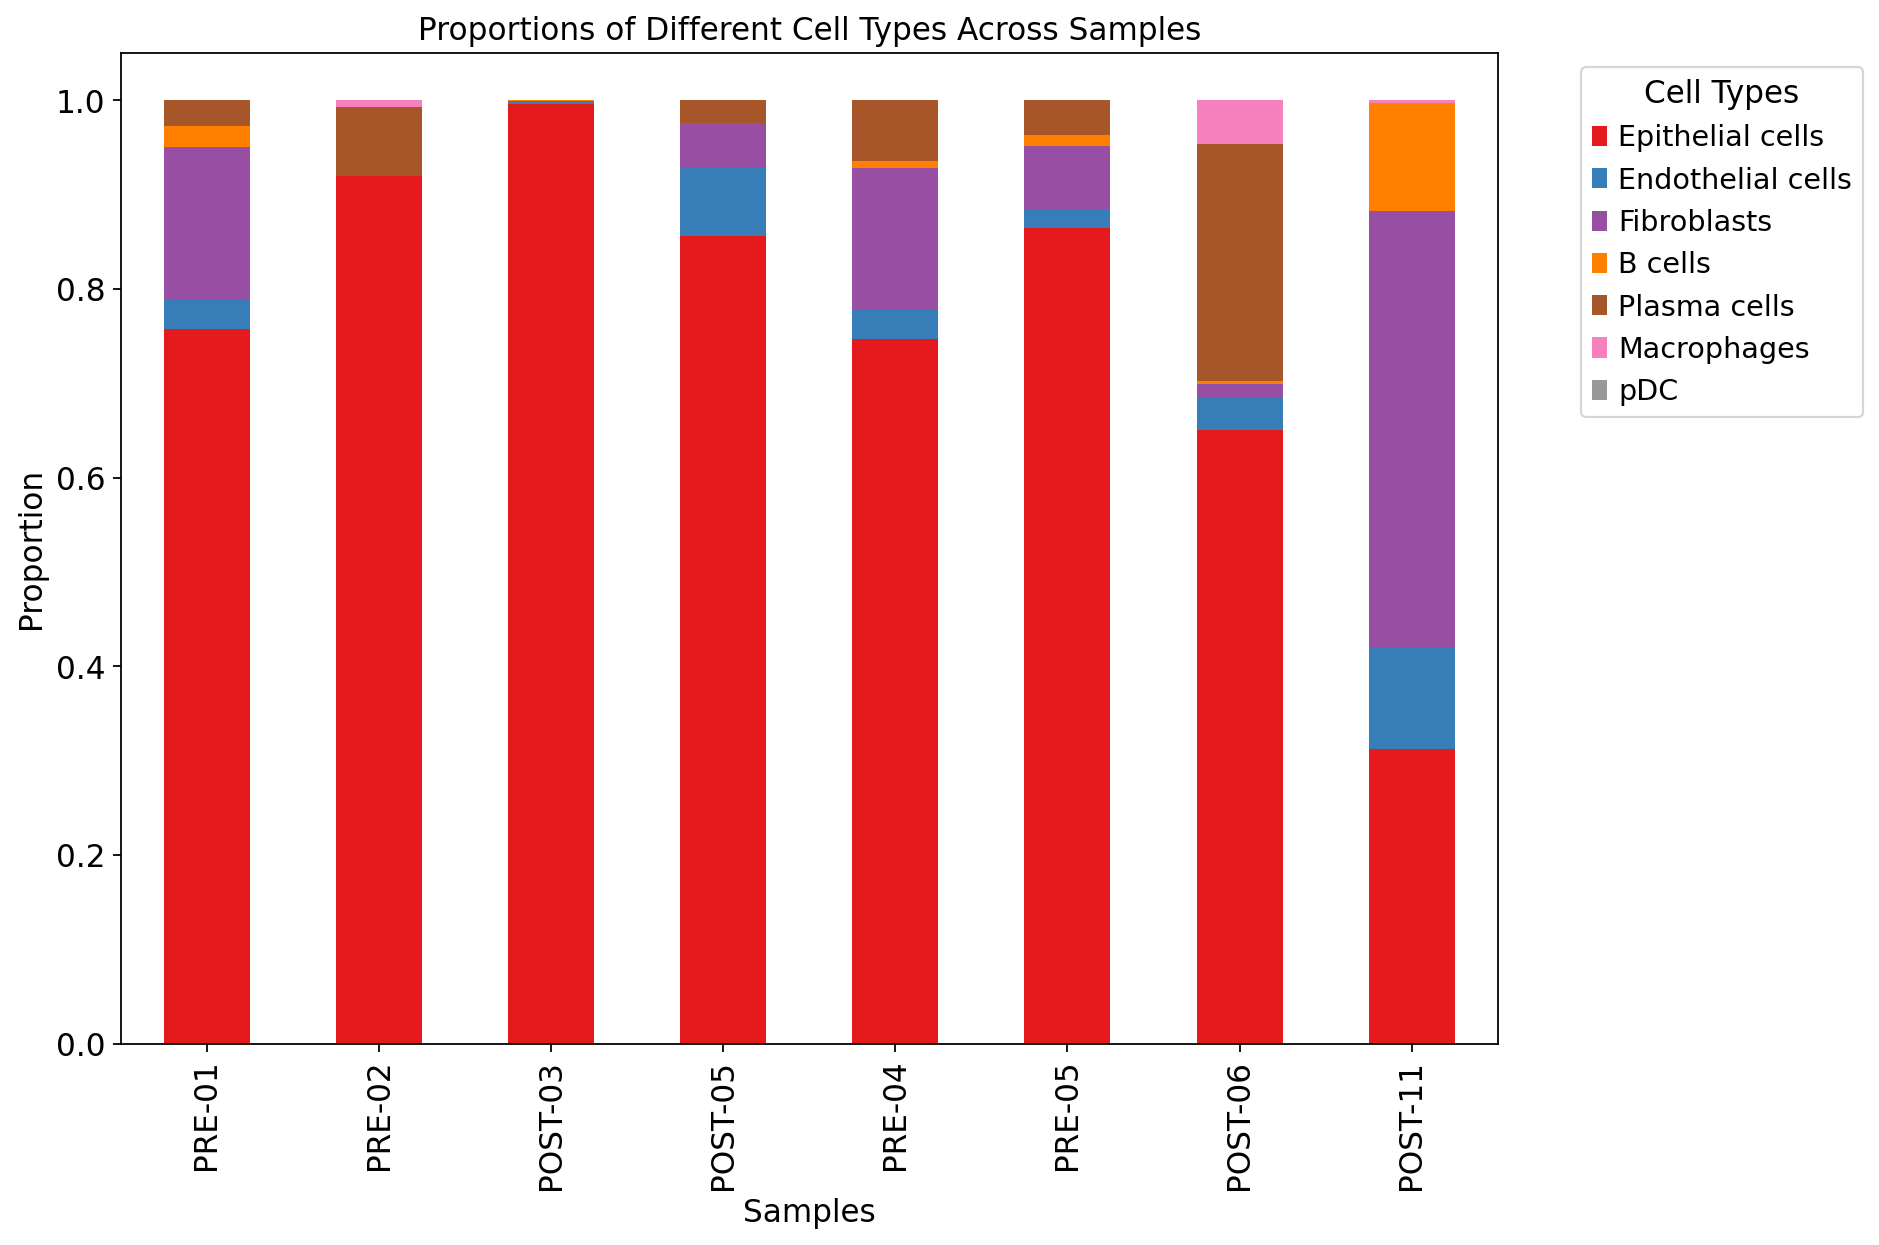

In [6]:
# Plotting the stacked bar graph
ax = combined_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')  # Higher contrast color map

# Remove grid lines
plt.grid(False)

# Adding title and labels
plt.title('Proportions of Different Cell Types Across Samples')
plt.xlabel('Samples')
plt.ylabel('Proportion')
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

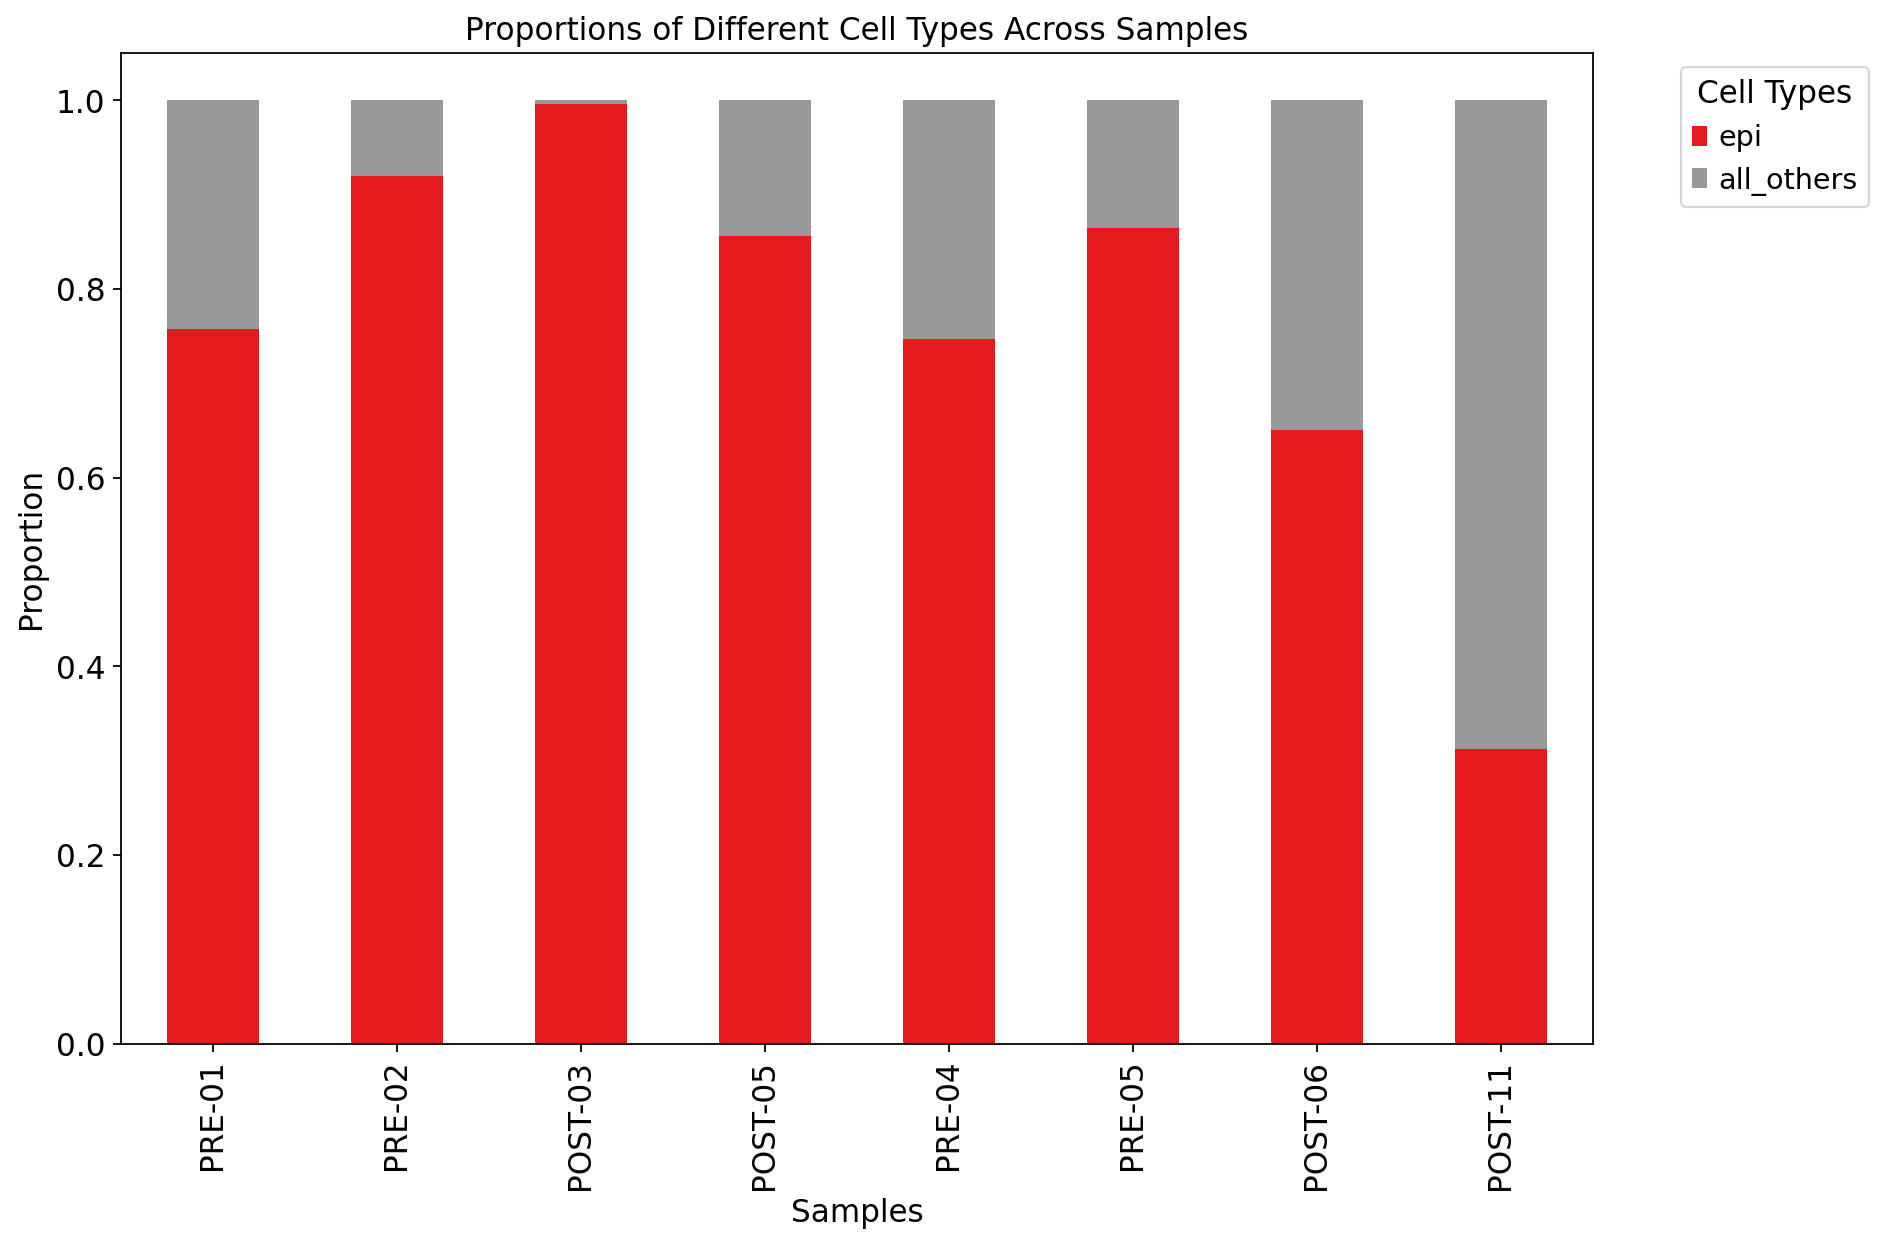

In [7]:
# Plotting the stacked bar graph
ax = simple_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')  # Higher contrast color map

# Remove grid lines
plt.grid(False)

# Adding title and labels
plt.title('Proportions of Different Cell Types Across Samples')
plt.xlabel('Samples')
plt.ylabel('Proportion')
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

In [31]:
# setup a dataframe for the heatmap plot

simple_df = pd.DataFrame(data=simple_cateogories)

signature_scores_df = pd.DataFrame(columns=signature_groups_list, index = sample_names)

for sample in sample_names:
    current_data = visium_samples[sample]
    for signature in signature_groups_list:
        signature_scores_df.at[sample, signature] = np.mean(current_data.obs[signature])

column_values = simple_df['all_others']

immune_invasiveness_ascending = column_values.sort_values(ascending=True).index.tolist()
signature_scores_df = signature_scores_df.loc[immune_invasiveness_ascending]

In [32]:
from scipy.stats import zscore

signature_scores_df = signature_scores_df.apply(pd.to_numeric, errors='coerce')
signature_scores_df_z = signature_scores_df.apply(zscore)

In [153]:
#altnerate code for ordering the samples, based on averaging a varibale present within the adata objects

current_variable = 'B-cells_cos_sim'
current_variable = 'T-cells_cos_sim'
current_variable = 'CAFs_cos_sim'

mean_list = [(sample_name, np.mean(visium_samples[sample_name].obs[current_variable])) for sample_name in visium_samples]

only_means_list = [t[1] for t in mean_list]  #take the second member of the tuples

# Convert the list of tuples into a DataFrame
# mean_df = pd.DataFrame(mean_list, columns=['Sample_Name', current_variable])

mean_df = pd.DataFrame(only_means_list, index=[sample_names], columns = [current_variable])

sorted_mean_df = mean_df.sort_values(by=current_variable, ascending=True)

rownames = sorted_mean_df.index.tolist()
rownames = [t[0] for t in rownames]
# Display the DataFrame
print(sorted_mean_df)

signature_scores_df = signature_scores_df.loc[rownames]

from scipy.stats import zscore

signature_scores_df = signature_scores_df.apply(pd.to_numeric, errors='coerce')
signature_scores_df_z = signature_scores_df.apply(zscore)

signature_scores_df_z

         CAFs_cos_sim
POST-05      0.317337
POST-11      0.329060
PRE-04       0.339667
PRE-01       0.394997
POST-06      0.398264
PRE-02       0.461038
PRE-05       0.462078
POST-03      0.481650


,Messina_chemokine,Cabrita_tls,Goff_Cell proliferation,Goff_Myeloid inflammatory,Goff_Agpresentation,Goff_B cells,Goff_NK cells,Zhang_hM01_Mast-TPSAB1,Zhang_hM02_pDC-LILRA4,Zhang_hM03_cDC2-CD1C,...,Zhang_hM09_Macro-PLTP,Zhang_hM10_Macro-IL1B,Zhang_hM12_TAM-C1QC,Zhang_hM13_TAM-SPP1,Davidson_suppressive,Davidson_costimulatory,Yang_Bcells,Rooney_cytolytic,Ayers_IFNg,DN2_Bcells
POST-05,-1.914392,-1.519274,-0.140264,-0.947558,1.970344,-0.024701,-1.126470,-0.671194,-1.703512,-2.507468,...,-1.820263,-1.949867,-1.519602,0.967298,-1.568449,1.382711,-0.345327,-0.821932,-1.855284,-1.365802
POST-11,0.137846,1.113959,-1.600079,-1.504445,-0.535140,-1.047180,-0.697598,-2.126987,0.426240,0.553199,...,1.102637,-0.904759,-1.268982,-1.470162,1.697358,0.200223,-1.902145,1.457480,0.140062,1.330381
PRE-04,0.468995,-0.118682,-0.040525,0.219452,-0.357687,-0.796550,-0.322685,0.991609,0.272176,-0.394436,...,0.224357,0.122955,-0.324341,0.604307,0.444660,1.894073,-1.138387,-0.113766,0.200810,-0.092619
PRE-01,-0.861243,-0.249586,-0.058155,-0.208583,-1.071362,0.311535,0.197666,0.213260,-0.086108,0.173486,...,0.169485,0.110477,0.347359,-1.215442,0.941704,-0.821081,0.493728,-1.863300,-0.913842,-0.626069
POST-06,1.053893,0.903730,0.294711,0.804826,0.855810,-0.307794,-0.248030,0.867026,0.989109,0.554658,...,1.495716,0.710509,0.560681,0.960332,0.359691,-0.569685,0.201539,0.754739,1.350799,1.814188
PRE-02,-0.210073,-1.386047,2.177726,0.918474,-0.262696,-0.367537,2.248371,-0.132593,0.232985,0.621809,...,-0.982392,1.038485,0.949158,0.535197,-1.028815,-0.754722,1.169801,-0.457453,-0.190533,-0.529506
PRE-05,1.475446,1.279113,0.122096,1.583281,-1.186943,-0.197282,0.675522,1.084613,1.311814,0.617384,...,-0.387645,1.269307,1.589879,0.752371,-0.542638,-0.719208,1.040970,0.079823,1.340398,0.089483
POST-03,-0.150473,-0.023213,-0.755510,-0.865447,0.587674,2.429509,-0.726777,-0.225734,-1.442704,0.381368,...,0.198104,-0.397108,-0.334152,-1.133902,-0.303510,-0.612312,0.479822,0.964409,-0.072410,-0.620056


<Figure size 640x480 with 0 Axes>

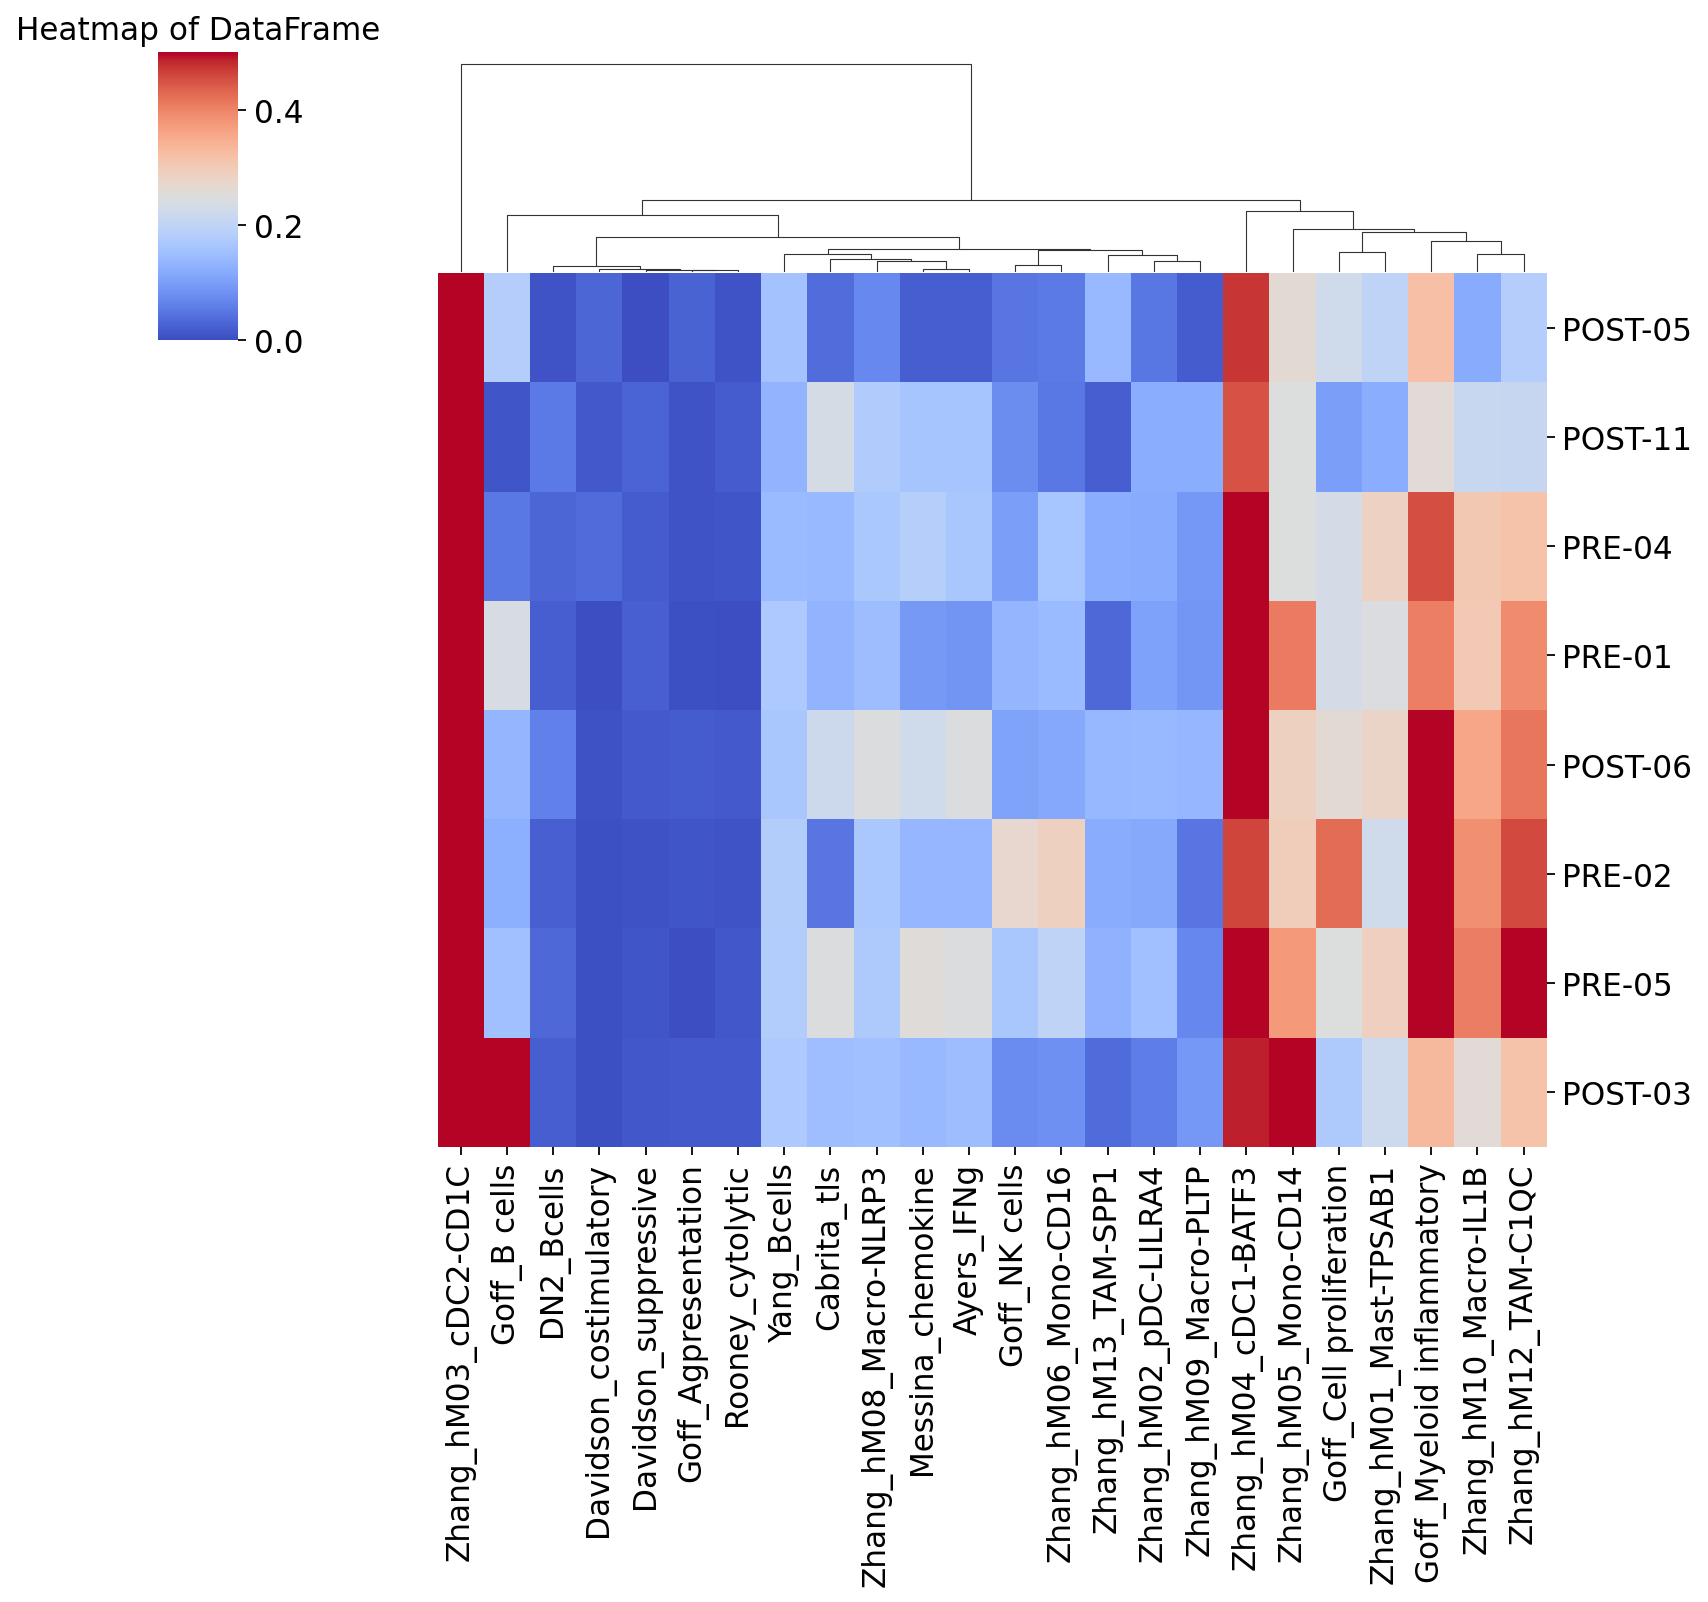

In [154]:
# Create a heatmap
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the figure
sb.clustermap(signature_scores_df, annot=False, cmap='coolwarm', fmt='.2f', col_cluster = True, row_cluster = False, vmax = 0.5,vmin=0)
plt.rcParams["axes.grid"] = False

# Show the plot
plt.title('Heatmap of DataFrame')
plt.show()

<Figure size 800x480 with 0 Axes>

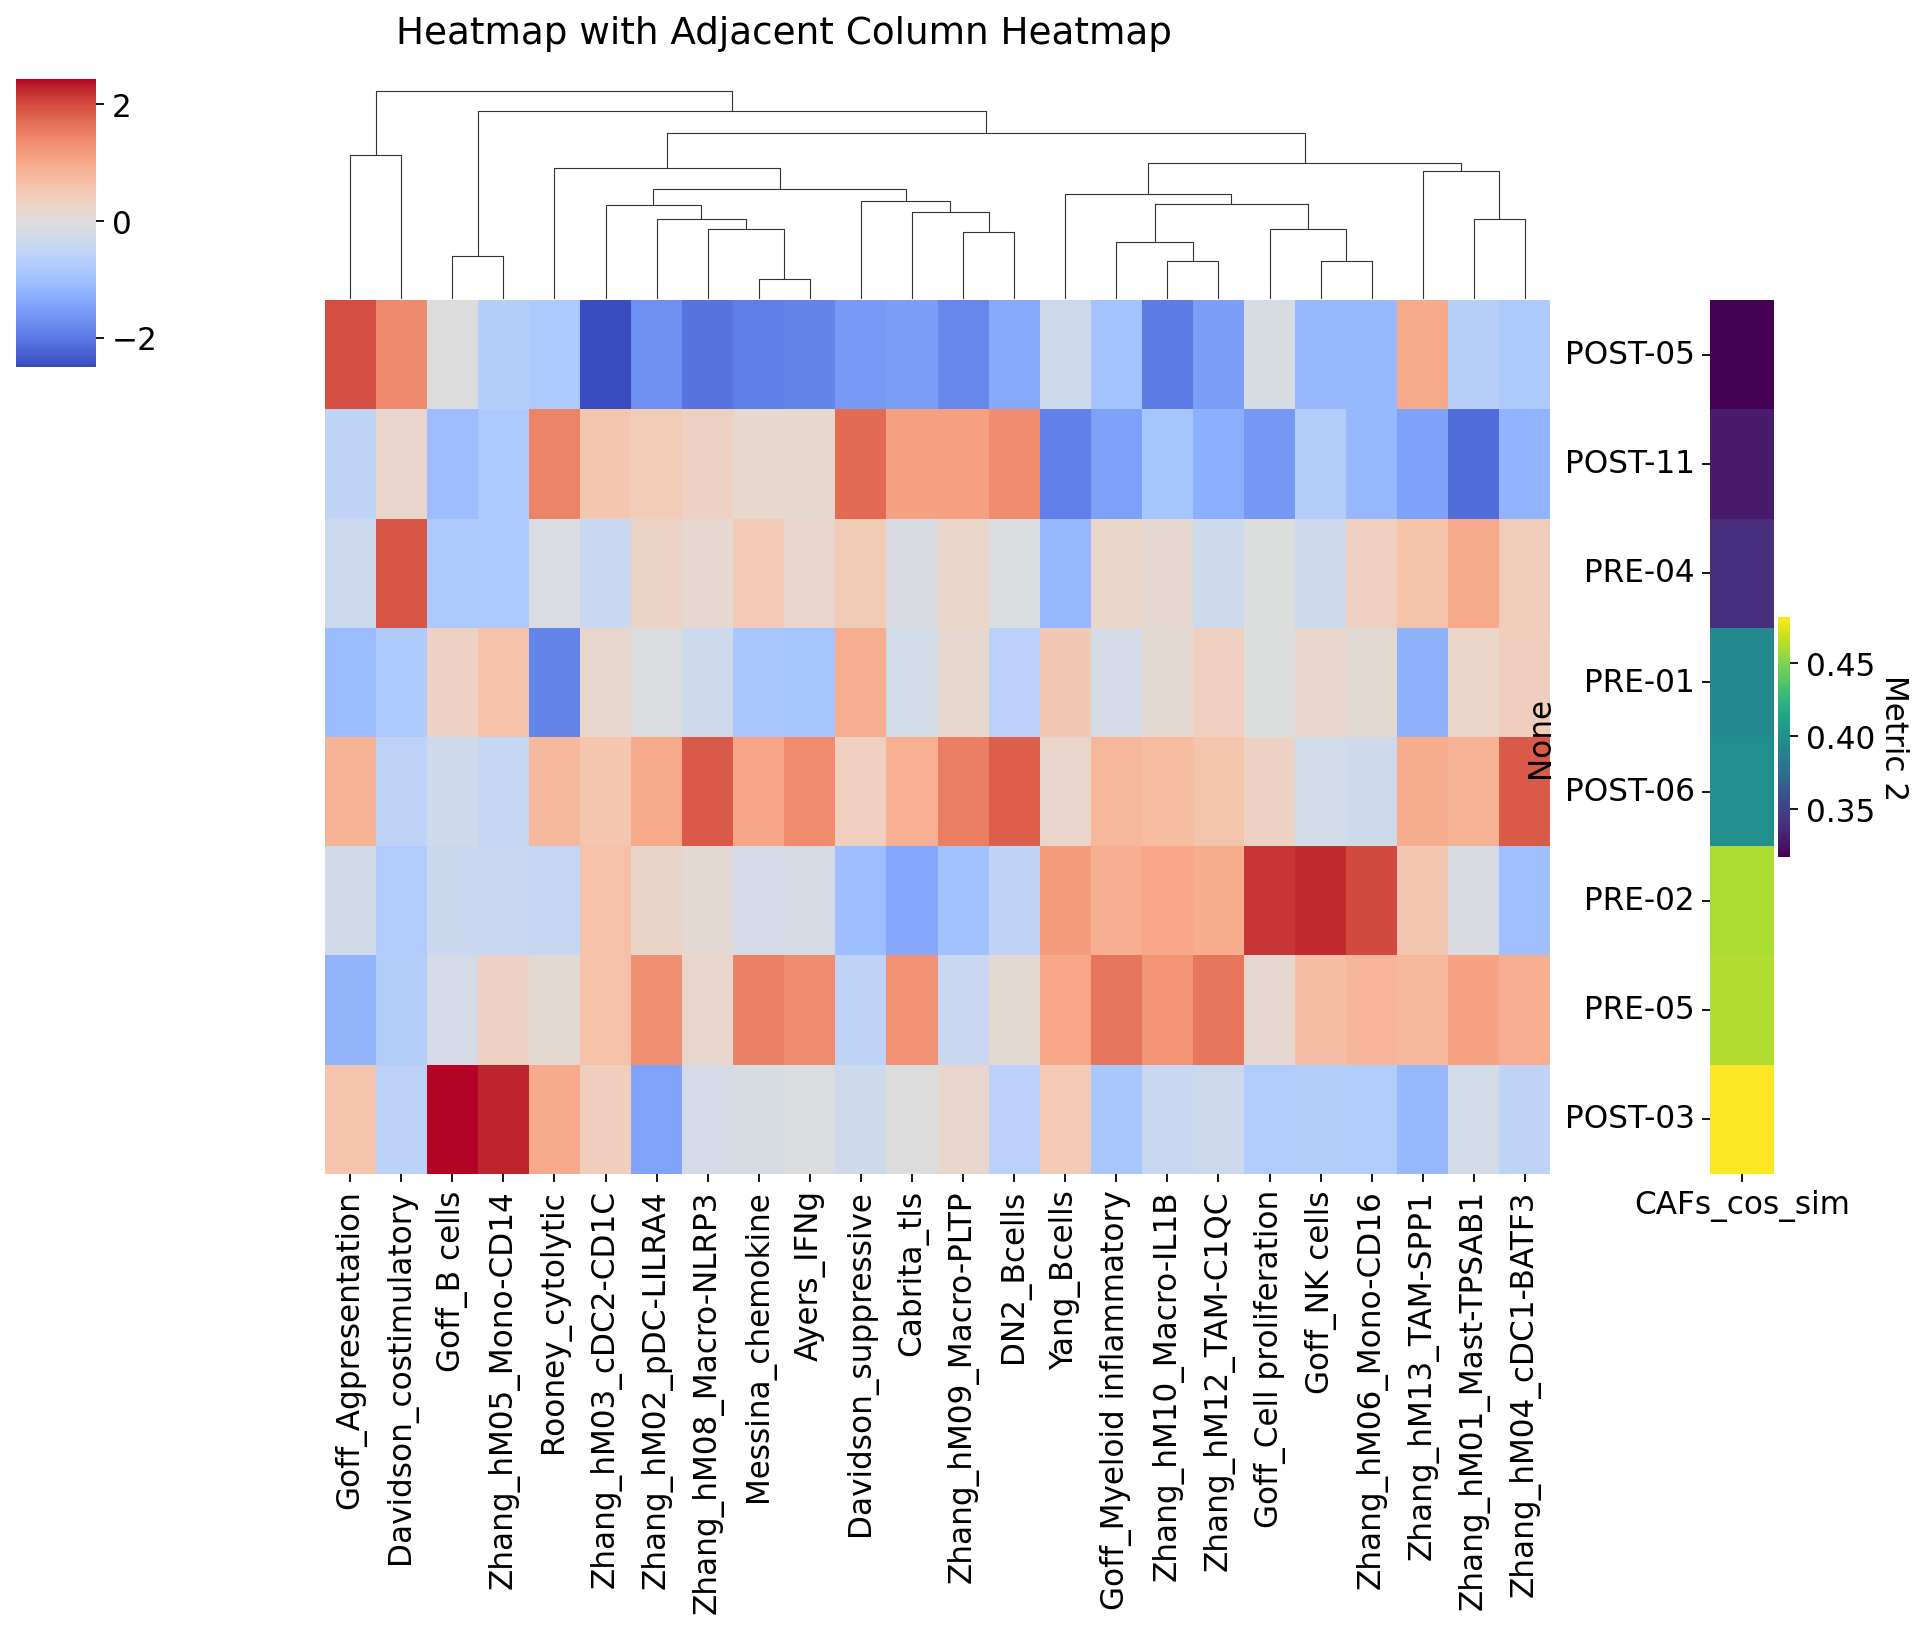

In [155]:
import matplotlib.pyplot as plt
import seaborn as sb

# Create the primary heatmap using clustermap
plt.figure(figsize=(10, 6))  # Increase figure width to accommodate both heatmaps
clusterMapPlot = sb.clustermap(signature_scores_df_z, annot=False, cmap='coolwarm', fmt='.2f', col_cluster=True, row_cluster=False, yticklabels=False)
plt.rcParams["axes.grid"] = False

# Ensure df2 is a DataFrame with a single column
df2 = simple_df[['epi']]  # Make sure it's a DataFrame, not a Series

df2 = sorted_mean_df[[current_variable]]

# Place the second heatmap farther away from the first one
# Use the same row order as the first heatmap (since no row clustering is applied)
heatmap_ax = clusterMapPlot.ax_heatmap  # The axis of the main heatmap
x, y, width, height = heatmap_ax.get_position().bounds

# Add a new axis for the second heatmap with increased space
ax2 = clusterMapPlot.fig.add_axes([x + width + 0.1, y, 0.05, height])  # Increase spacing here

# Plot the second heatmap
sb.heatmap(df2.loc[signature_scores_df_z.index], cmap='viridis', cbar=True, ax=ax2, annot=False)

# Adjust colorbar position
colorbar = ax2.collections[0].colorbar
colorbar.ax.set_ylabel('Metric 2', rotation=270, labelpad=15)

# Adjust the title to avoid overlap
clusterMapPlot.fig.suptitle('Heatmap with Adjacent Column Heatmap', y=1.02)

# Show the plot
plt.show()

In [131]:
for signature in signature_groups_list:
    fig, axs = plt.subplots(8, 1, sharey=True, figsize=(10, 20))  # Increase the height and width
    nbins = 20
    distributions = [visium_samples[name].obs[signature] for name in immune_invasiveness_ascending]
    # distributions = [dist1, dist2, dist3, dist4, dist5, dist6, dist7, dist8]
    labels = sample_names
    
    for ax, dist, name in zip(axs, distributions, immune_invasiveness_ascending):
        counts, bins, patches = ax.hist(dist, bins=20, density=True, alpha=0.6, color='blue', edgecolor='black')
        
        current_epi_percent = simple_df.loc[name,'epi']

        ax.text(0.95,  0.95, 
            f'Epi %: {current_epi_percent:.2f}',  horizontalalignment='right', verticalalignment='top',  
            transform=ax.transAxes,  # critical arguments that positions text relative to axes dimensions and note the data values
            fontsize=10,  
            color='black',  
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.5) 
        )

        ax.set_title(name)
        ax.set_xlabel(signature + ' score')
        ax.set_ylabel('Density')
        ax.set_xlim(0, 1)
    
    # Adjust layout to fit subplots nicely
    plt.tight_layout()
    
    # Show the plot
    
    dir_name = "/tmp/work/Visium/BRCA_2024/figures" 
    pdf_path = os.path.join(dir_name, signature + '_histogram' + '.' + 'pdf')
        
    plt.savefig(pdf_path, format='pdf')
    plt.close(fig)

In [ ]:
# from os import sys
# sys.path.append('/tmp/work/Visium/BRCA_2024/brca_scripts')
# from getBulkSigScores import getBulkSigs

# test = getBulkSigs()

In [50]:
import statistics as stat

print(stat.mean(visium_samples['POST-03'].obs['B-cells_cos_sim']))

print(stat.mean(visium_samples['PRE-02'].obs['B-cells_cos_sim']))

print(stat.mean(visium_samples['PRE-05'].obs['B-cells_cos_sim']))

print(stat.mean(visium_samples['POST-05'].obs['B-cells_cos_sim']))

print(stat.mean(visium_samples['PRE-01'].obs['B-cells_cos_sim']))

print(stat.mean(visium_samples['PRE-04'].obs['B-cells_cos_sim']))

print(stat.mean(visium_samples['POST-06'].obs['B-cells_cos_sim']))

print(stat.mean(visium_samples['POST-11'].obs['B-cells_cos_sim']))



0.2839173902635989
0.2731563850338089
0.26919720052203594
0.14906334247373845
0.2586363631189767
0.2563016680411309
0.23225039994520835
0.3339158503224163


In [51]:
visium_samples['POST-03']

AnnData object with n_obs × n_vars = 2990 × 18018
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'clusters', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'B-cells_cos_sim', 'CAFs_cos_sim', 'Cancer Epithelial_cos_sim', 'Endothelial_cos_sim', 'Myeloid_cos_sim', 'Normal Epithelial_cos_sim', 'PVL_cos_sim', 'Plasmablasts_cos_sim', 'T-cells_cos_sim', 'Messina_chemokine', 'Cabrita_tls', 'Goff_Cell proliferation', 'Goff_Myeloid inflammatory', 'Goff_Agpresentation', 'Goff_B cells', 'Goff_NK cells', 'Zhang_hM01_Mast-TPSAB1', 'Zhang_hM02_pDC-LILRA4', 'Zhang_hM03_cDC2-CD1C', 'Zhang_hM04_cDC1-BATF3', 'Zhang_hM05_Mono-CD14', 'Zhang_hM06_Mono-CD16', 'Zhang_hM08_Macro-NLRP3', 'Zhang_hM0

In [156]:
df2

,CAFs_cos_sim
POST-05,0.317337
POST-11,0.329060
PRE-04,0.339667
PRE-01,0.394997
POST-06,0.398264
PRE-02,0.461038
PRE-05,0.462078
POST-03,0.481650
